In [1]:
# DATA CLEANING
import pandas as pd
df = pd.read_csv('events.csv')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from datetime import datetime
df['date'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour
df.head()

,timestamp,visitorid,event,itemid,transactionid,date,year,month,day,dayofweek,hour
0,1433221332117,257597,view,355908,NaN,2015-06-02 07:02:12.117,2015,6,2,1,7
1,1433224214164,992329,view,248676,NaN,2015-06-02 07:50:14.164,2015,6,2,1,7
2,1433221999827,111016,view,318965,NaN,2015-06-02 07:13:19.827,2015,6,2,1,7
3,1433221955914,483717,view,253185,NaN,2015-06-02 07:12:35.914,2015,6,2,1,7
4,1433221337106,951259,view,367447,NaN,2015-06-02 07:02:17.106,2015,6,2,1,7


In [2]:
#########@ CALCULER LE TEMPS MOYEN PASSE PAR TRANSACTION (24H) ###########################
# Diviser entre transactions et le reste
non_transactions = df.loc[df.event != "transaction"]
transactions = df.loc[df.event == "transaction"]

# Merger les deux tableaux afin de calculer le temps passé entre 2 actions successives
inner_merged_total = pd.merge(transactions, non_transactions, on=["visitorid"], how="inner")

# Calculez la différence entre l'heure à laquelle la transaction s'est produite
# et l'heure à laquelle chaque événement s'est produit
inner_merged_total['time_diff'] = inner_merged_total['date_x'] - inner_merged_total['date_y']

# Trier le dataframe par visitorid...
inner_merged_total = inner_merged_total.sort_values(by=['visitorid','date_x','date_y','itemid_x'])

# Appliquer 2 conditions importantes pour définir une visite convertissante : 
# Premièrement, time_diff est moins de 24h. Deuxièmement, le itemid sur lequel la transaction 
# a eu lieu et le itemid sur lequel chaque événement s'est produit doivent être les mêmes
transaction_24h = inner_merged_total.loc[inner_merged_total['time_diff'].dt.days < 1]
transaction_made_24h = transaction_24h.loc[inner_merged_total['itemid_x'] == inner_merged_total['itemid_y']]

# Supprimer certaines colonnes
transaction_made_24h = transaction_made_24h.drop(['timestamp_x','timestamp_y','transactionid_y'], axis=1)

# Convertir 'time_diff' en timedelta en seconds
transaction_made_24h['time_diff_sec'] = transaction_made_24h['time_diff'].dt.seconds

# drop, change colonne
transaction_made_24h = transaction_made_24h.drop(['year_x','month_x','day_x','dayofweek_x','hour_x'], axis=1)
transaction_made_24h = transaction_made_24h.drop(['year_y','month_y','day_y','dayofweek_y','hour_y'], axis=1)
transaction_made_24h

,visitorid,event_x,itemid_x,transactionid_x,date_x,event_y,itemid_y,date_y,time_diff,time_diff_sec
10069099,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:06:38.438,0 days 00:22:22.792000,1342
10069108,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,addtocart,465522,2015-08-15 03:13:39.691,0 days 00:15:21.539000,921
10069105,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,addtocart,465522,2015-08-15 03:13:48.324,0 days 00:15:12.906000,912
10069098,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:27:09.037,0 days 00:01:52.193000,112
10069106,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:27:27.421,0 days 00:01:33.809000,93
...,...,...,...,...,...,...,...,...,...,...
9743949,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 00:57:13.885,0 days 00:14:11.739000,851
9743946,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 01:00:26.861,0 days 00:10:58.763000,658
9743942,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 01:03:14.670,0 days 00:08:10.954000,490
9743943,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,addtocart,360922,2015-08-05 01:05:35.724,0 days 00:05:49.900000,349


In [31]:
# Nombre de visites par itemsid
items = df.groupby('itemid').agg({'visitorid':'count'})
items = items.rename(columns={"visitorid": "nb_visites"})

# Nombre de views par itemid
items_view = df.loc[df['event'] == 'view'].groupby('itemid').agg({'itemid':'count'}) #df.loc[df['itemid'] == 9]
items_view = items_view.rename(columns={"itemid": "nb_views"})

# Nombre de addtocarts par itemid
items_addtocart = df.loc[df['event'] == 'addtocart'].groupby('itemid').agg({'itemid':'count'})
items_addtocart = items_addtocart.rename(columns={"itemid": "nb_addtocarts"})

# Nombre de transactions par itemid
items_transaction = df.loc[df['event'] == 'transaction'].groupby('itemid').agg({'itemid':'count'})
items_transaction = items_transaction.rename(columns={"itemid": "nb_transactions"})

# Merge dataframes
items = pd.merge(items, items_view, left_index=True, right_index=True, how='left')
items = pd.merge(items, items_addtocart, left_index=True, right_index=True, how='left')
items = pd.merge(items, items_transaction, left_index=True, right_index=True, how='left')
items

# Remplaçons les Nans par 0 
items = items.fillna(0)
# Vérifions que les Nans ont bien été remplacé
#items.isnull().sum(axis = 0)
items

,nb_visites,nb_views,nb_addtocarts,nb_transactions
itemid,,,,
3,2,2.0,0.0,0.0
4,3,3.0,0.0,0.0
6,29,29.0,0.0,0.0
9,2,2.0,0.0,0.0
15,22,18.0,3.0,1.0
...,...,...,...,...
466861,95,89.0,5.0,1.0
466862,4,4.0,0.0,0.0
466863,1,1.0,0.0,0.0


In [32]:
group_item = transaction_made_24h.groupby('itemid_x')

# Calculer le temps moyen par item - heure, minute, second
time_mean_item = transaction_made_24h.groupby(by=['itemid_x']).mean()
time_mean_item = time_mean_item.drop(['transactionid_x','itemid_y','visitorid'], axis=1)
time_mean_item = time_mean_item.rename(columns={"time_diff_sec": "mean_time_second"})
time_mean_item['mean_time_minute'] = round(time_mean_item['mean_time_second']/60)
time_mean_item['mean_time_hour'] = round(time_mean_item['mean_time_second']/3600,2)

#### PAR ITEMS
#transactions_items = df.loc[df['transactionid'] > 0].groupby(by='itemid').agg({'transactionid': 'count'})
#transactions_items = transactions_items.rename(columns={"transactionid": "nb_transactions"})
#stats = pd.merge(stats, items, left_index=True, right_index=True, how='left')
#transactions_items = transactions_items.sort_values(by='nb_transactions', ascending=False)

time_mean_item = pd.merge(items, time_mean_item, left_index=True, right_index=True, how='left')
time_mean_item = time_mean_item.sort_values(by=['nb_transactions'], ascending=False)
time_mean_item = time_mean_item.fillna(0)
time_mean_item



,nb_visites,nb_views,nb_addtocarts,nb_transactions,mean_time_second,mean_time_minute,mean_time_hour
itemid,,,,,,,
461686,2978,2539.0,306.0,133.0,16110.102459,269.0,4.48
119736,893,752.0,44.0,97.0,36639.016032,611.0,10.18
213834,402,293.0,17.0,92.0,36446.015873,607.0,10.12
312728,1155,947.0,162.0,46.0,28218.788360,470.0,7.84
7943,1489,1346.0,97.0,46.0,17177.036810,286.0,4.77
...,...,...,...,...,...,...,...
159357,1,1.0,0.0,0.0,0.000000,0.0,0.00
159359,13,13.0,0.0,0.0,0.000000,0.0,0.00
159362,2,2.0,0.0,0.0,0.000000,0.0,0.00


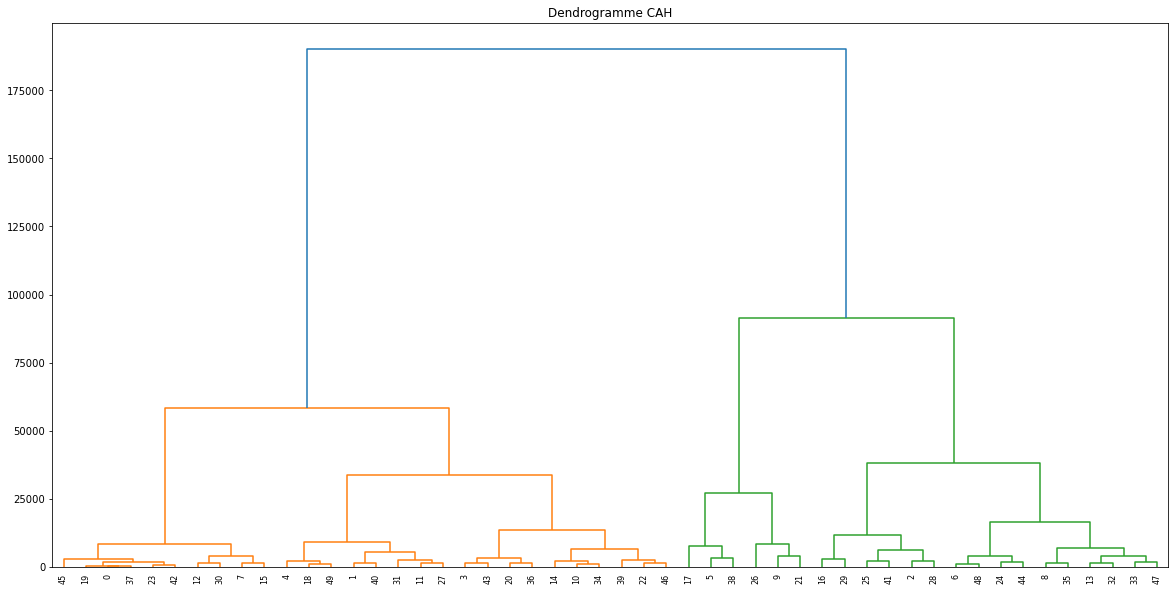

In [27]:
k1 = KMeans(n_clusters=50).fit(time_mean_item)

# 2. DENDROGRAMME TO GET OPTIMAL N_CLUSTER
plt.figure(figsize=(20, 10))
Z = linkage(k1.cluster_centers_, method='ward', metric='euclidean')
plt.title("Dendrogramme CAH")
dendrogram(Z, leaf_rotation=90.)
plt.show()

In [33]:
################@ RESULTATS : CLUSTERING PAR LE TEMPS MOYEN PASSE PAR TRANSATIONS ######################
# AGGLOMERATIVECLUSTERING PAR 4
ac = AgglomerativeClustering(n_clusters = 4).fit(k1.cluster_centers_)
cd = pd.DataFrame(k1.cluster_centers_)

time_mean_item['kmean1_label'] = k1.labels_

# DATA CLUSTERING    
for i in list(cd.index):
    time_mean_item.loc[time_mean_item['kmean1_label'] == cd.index[i], 'agglo_label'] = ac.labels_[i]

# GET NEW CENTROIDS = MEAN OF AGGLO 4 LABELS
new_centroids = time_mean_item.groupby('agglo_label').mean()
new_time_mean_item = time_mean_item.drop(['agglo_label'], axis=1)

k2 = KMeans(n_clusters=4, init=new_centroids)
k2.fit(new_time_mean_item)

# Centroids and labels
k2_centroids = k2.cluster_centers_
k2_labels = k2.labels_

time_mean_item['kmean2_label'] = k2.labels_
time_mean_item

/Users/sooyounglee/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,nb_visites,nb_views,nb_addtocarts,nb_transactions,mean_time_second,mean_time_minute,mean_time_hour,kmean1_label,agglo_label,kmean2_label
itemid,,,,,,,,,,
461686,2978,2539.0,306.0,133.0,16110.102459,269.0,4.48,39,1.0,1
119736,893,752.0,44.0,97.0,36639.016032,611.0,10.18,8,0.0,0
213834,402,293.0,17.0,92.0,36446.015873,607.0,10.12,8,0.0,0
312728,1155,947.0,162.0,46.0,28218.788360,470.0,7.84,40,1.0,1
7943,1489,1346.0,97.0,46.0,17177.036810,286.0,4.77,22,1.0,1
...,...,...,...,...,...,...,...,...,...,...
159357,1,1.0,0.0,0.0,0.000000,0.0,0.00,0,3.0,3
159359,13,13.0,0.0,0.0,0.000000,0.0,0.00,0,3.0,3
159362,2,2.0,0.0,0.0,0.000000,0.0,0.00,0,3.0,3


Text(0.5, 1.0, 'Temps moyen par transaction')

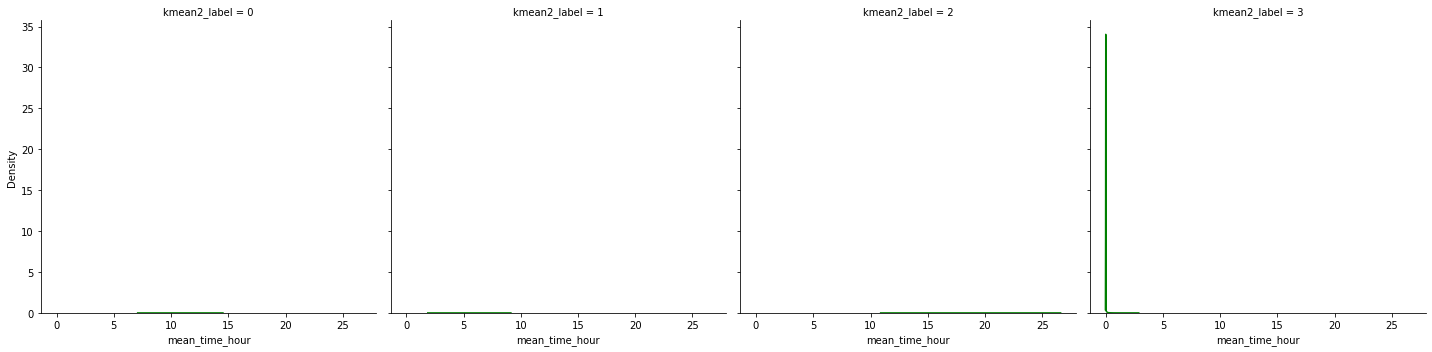

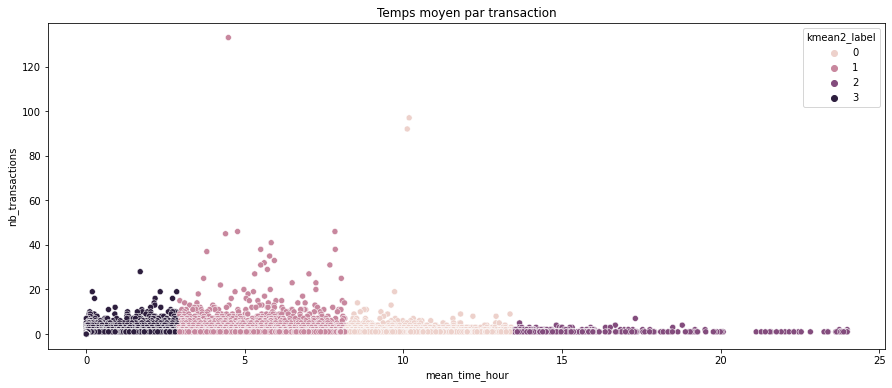

In [34]:
sns.displot(data=time_mean_item, x="mean_time_hour", col="kmean2_label", kind="kde", color='green')

plt.figure(figsize=(15,6))
sns.scatterplot(data=time_mean_item, x="mean_time_hour", y="nb_transactions", hue="kmean2_label")
plt.title('Temps moyen par transaction')

In [53]:
n_produits = 500

# les n_produits produits plus achetés
top_produits_vendus = items.sort_values(by='nb_transactions', ascending=False).head(n_produits)
top_produits_vendus['cat_top_vendus'] = "1"
top_produits_vendus = top_produits_vendus.drop(columns=['nb_visites', 'nb_views', 'nb_addtocarts'])

# les n_produits produits plus mis au panier
top_produits_paniers = items.sort_values(by='nb_addtocarts', ascending=False).head(n_produits)
top_produits_paniers['cat_top_mis_panier'] = "1"
top_produits_paniers = top_produits_paniers.drop(columns=['nb_visites', 'nb_views', 'nb_transactions'])

# les n_produits produits plus vus
top_produits_vus = items.sort_values(by='nb_views', ascending=False).head(n_produits)
top_produits_vus['cat_top_vus'] = "1"
top_produits_vus = top_produits_vus.drop(columns=['nb_visites', 'nb_addtocarts', 'nb_transactions'])

# Merge les 3 dataframes OUTER
top_produits = pd.merge(top_produits_vendus, top_produits_paniers, left_index=True, right_index=True, how='outer')
top_produits = pd.merge(top_produits, top_produits_vus, left_index=True, right_index=True, how='outer')

top_produits = top_produits[['cat_top_vus', 'cat_top_mis_panier', 'cat_top_vendus']]
top_produits = top_produits.fillna(0)
top_produits

,cat_top_vus,cat_top_mis_panier,cat_top_vendus
itemid,,,
546,1,1,1
829,0,1,0
869,1,1,1
1684,0,0,1
2416,0,1,1
...,...,...,...
465511,1,1,0
465522,0,1,1
465751,0,0,1


In [54]:
top_produits_merged = pd.merge(top_produits, time_mean_item, left_index=True, right_index=True, how='left')
top_produits_merged = top_produits_merged.sort_values(by=['nb_transactions'], ascending=False)
top_produits_merged

,cat_top_vus,cat_top_mis_panier,cat_top_vendus,nb_visites,nb_views,nb_addtocarts,nb_transactions,mean_time_second,mean_time_minute,mean_time_hour,kmean1_label,agglo_label,kmean2_label
itemid,,,,,,,,,,,,,
461686,1,1,1,2978,2539.0,306.0,133.0,16110.102459,269.0,4.48,39,1.0,1
119736,1,1,1,893,752.0,44.0,97.0,36639.016032,611.0,10.18,8,0.0,0
213834,0,1,1,402,293.0,17.0,92.0,36446.015873,607.0,10.12,8,0.0,0
312728,1,1,1,1155,947.0,162.0,46.0,28218.788360,470.0,7.84,40,1.0,1
7943,1,1,1,1489,1346.0,97.0,46.0,17177.036810,286.0,4.77,22,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
328692,1,0,0,309,309.0,0.0,0.0,0.000000,0.0,0.00,37,3.0,3
91755,1,0,0,1024,1024.0,0.0,0.0,0.000000,0.0,0.00,45,3.0,3
335975,1,0,0,1428,1428.0,0.0,0.0,0.000000,0.0,0.00,45,3.0,3


/Users/sooyounglee/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


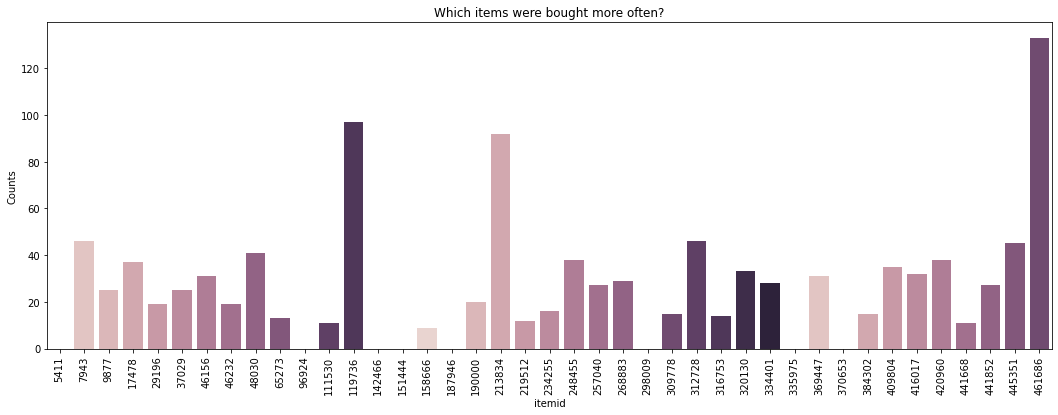

In [48]:
plt.figure(figsize=(18,6))
sns.barplot(top_produits_merged.index, top_produits_merged.nb_transactions, palette=sns.cubehelix_palette(15))
plt.ylabel("Counts")
plt.title("Which items were bought more often?");
plt.xticks(rotation=90);

<AxesSubplot:xlabel='mean_time_hour', ylabel='nb_transactions'>

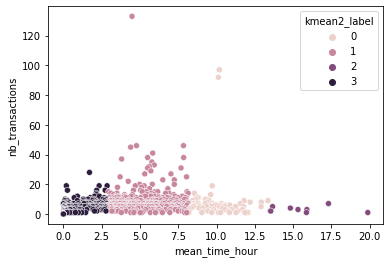

In [55]:
# CLUSTERING SUR TOP 500 PRODUITS
sns.scatterplot(data=top_produits_merged, hue="kmean2_label", y="nb_transactions", x="mean_time_hour")
